## Malicious URLs

Dataset Source: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset

#### Install Necessary Libraries

In [1]:
%pip install torch transformers evaluate datasets
%pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.3 MB/s eta 0:00:00


#### Mount Google Drive to Notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Necessary Libraries

In [3]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, Trainer, set_seed

import evaluate

!git lfs install

Git LFS initialized.


#### HuggingFace Access

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Display Library Versions

In [5]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.10.1
         NumPy: 1.23.5
        Pandas: 1.5.3
      Datasets: 2.14.4
  Transformers: 4.31.0
         Torch: 2.0.1+cu118
      Evaluate: 0.4.0


#### Load & Start Preprocessing Dataset

In [6]:
names = ["text",
         "label"]

data_types = {
    "text": str,
    "label": str,
    }

data = pd.read_csv("/content/drive/MyDrive/URLs/malicious_phish.csv",
                   names=names,
                   dtype=data_types,
                   header=0)

data['text'] = data['text'].drop_duplicates().reset_index(drop=True)

data['label'] = data['label'].apply(lambda x: x.strip())

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641119 entries, 0 to 641118
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    641119 non-null  object
 1   label   641119 non-null  object
dtypes: object(2)
memory usage: 14.7+ MB


#### Define Dictionaries to Convert Between String & Integer Class Values

In [7]:
unique_labels = data['label'].unique()

id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}

NUM_OF_LABELS = len(unique_labels)

print(unique_labels)
print(NUM_OF_LABELS)
print(label2id)
print(id2label)

['phishing' 'benign' 'defacement' 'malware']
4
{'phishing': 0, 'benign': 1, 'defacement': 2, 'malware': 3}
{0: 'phishing', 1: 'benign', 2: 'defacement', 3: 'malware'}


#### Visual: Histogram of Text Lengths

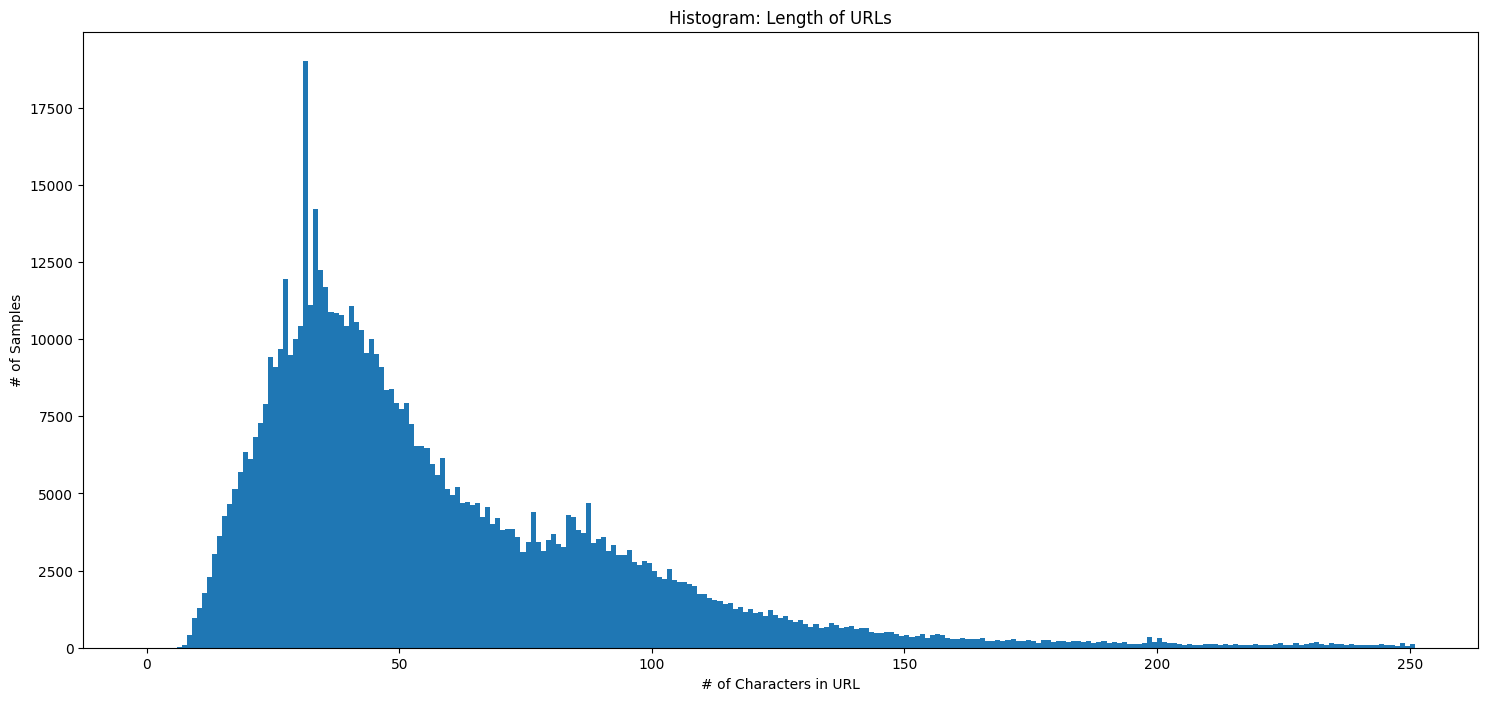

The maximum length of the URLs is 2175 characters.


In [8]:
data['text_length'] = data['text'].str.len()

n_bin=250
data.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin + 1), bins=(n_bin + 1))
plt.title('Histogram: Length of URLs')
plt.xlabel('# of Characters in URL')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of the URLs is {max(data['text_length'])} characters.")

#### Visual: Tweet Length by Class

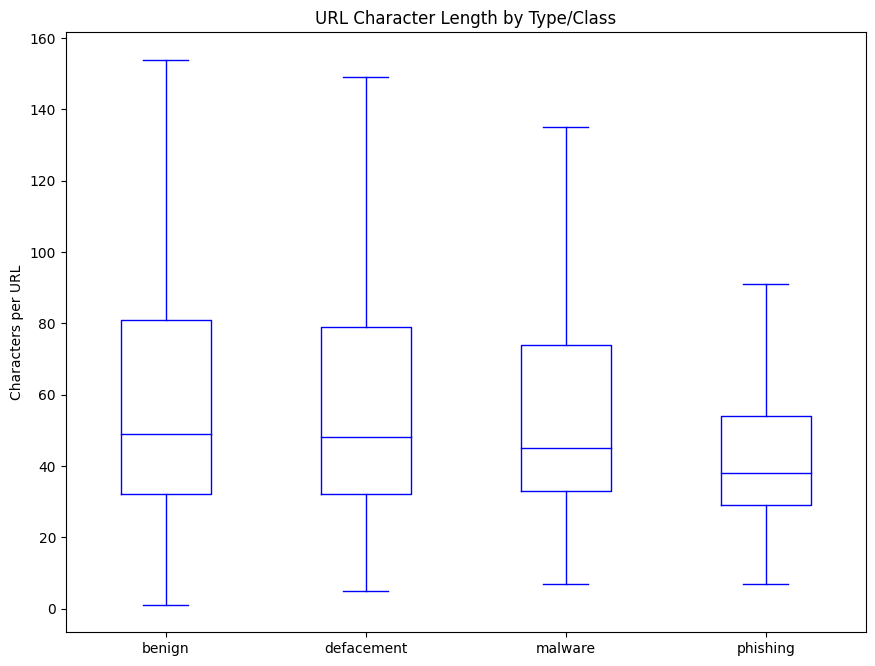

In [9]:
data.boxplot("text_length", by="label", grid=False, showfliers=False, color="Blue", figsize=(10,8))

plt.suptitle('')
plt.title('URL Character Length by Type/Class')
plt.xlabel('')
plt.ylabel('Characters per URL')
plt.show()

#### Final Data Preprocessing

In [10]:
data = data[data['text_length'] < 136]

data = data.drop(columns=["text_length"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609987 entries, 0 to 641118
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    609987 non-null  object
 1   label   609987 non-null  object
dtypes: object(2)
memory usage: 14.0+ MB


#### Barplot Function

In [11]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   show_class_amounts: bool = True
                   ):
    """
    This function returns a histogram for a feature.

    Inputs:
    - feature_to_visualize: Feature to plot in the form
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.

    Output:
    - A Bar Plot.
    """

    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."

    ax = feature_to_visualize.value_counts().plot.bar(
                                                      figsize=(8, 6),
                                                      rot=0,
                                                      legend=False,
                                                      color=["lightgreen",
                                                             "blue",
                                                             "brown",
                                                             "lightblue",
                                                             "tan",
                                                             "yellow",
                                                             "orange",
                                                             "green",
                                                             "red"]
                                                      )

    if show_class_amounts:
        ax.bar_label(ax.containers[0])

    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

#### Number of Samples in Each Class

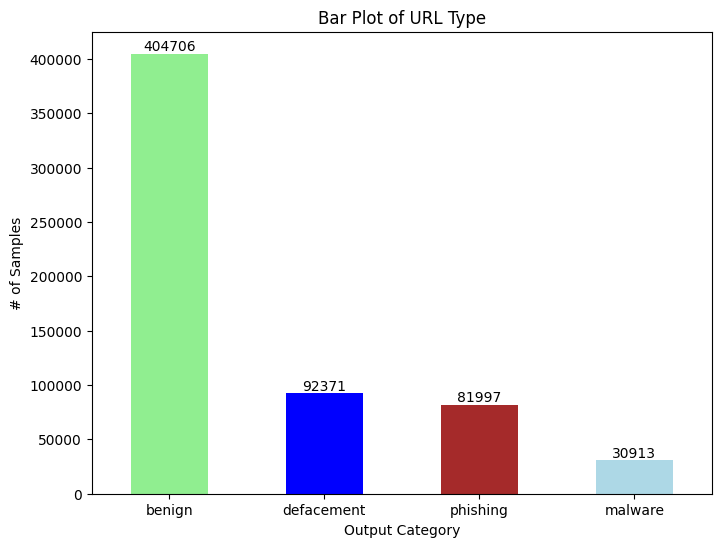

In [12]:
barplot_visual(data["label"],
               "Bar Plot of URL Type",
               "Output Category",
               "# of Samples",
               )

#### Convert Label Values From String to Integer

In [13]:
data['label'] = data['label'].replace(label2id).astype(np.int8)

#### Convert DataFrame to Dataset

In [14]:
dataset = Dataset.from_pandas(data)

#### Split Dataset into Training Evaluation Datasets

In [15]:
train_eval = dataset.train_test_split(train_size=0.67)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (408691, 3)
Evaluation Dataset Shape: (201296, 3)


#### Basic Values/Constants

In [16]:
set_seed = 42
NUM_OF_EPOCHS = 1

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = 176
MODEL_CKPT = "albert-base-v2"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Malicious_URLs"

METRIC_NAME = "f1"

print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will have a maximum length for the input text of 176 tokens.
The model checkpoint used for this project is: albert-base-v2


#### Tokenize Entire Dataset

In [17]:
# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Tokenize Method
def tokenize(batch):
    return tokenizer(batch['text'],
                     padding=True,
                     truncation=True,
                     max_length=MAX_LENGTH,
                     return_tensors="pt")

# Tokenize entire dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)

print('Training data shape:', encoded_data['train'].shape)
print('Validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

Map:   0%|          | 0/408691 [00:00<?, ? examples/s]

Map:   0%|          | 0/201296 [00:00<?, ? examples/s]

Training data shape: (408691, 6)
Validation data shape: (201296, 6)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int8', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 408691
})


#### Instantiate Model

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Function to Compute Metrics

In [19]:
def compute_metrics(p):
    """
    This function takes the predictions output from
    trainer.evaluate & returns metrics (accuracy, F1,
    recall, & precision) for a multiclass
    classification project.
    """
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions,
                                                             axis=1),
                                       references=p.label_ids)['accuracy']

    ### ------------------- F1 scores -------------------

    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions,
                                                                      axis=1),
                                                references=p.label_ids,
                                                average='weighted')["f1"]

    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions,
                                                                   axis=1),
                                             references=p.label_ids,
                                             average='micro')['f1']

    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions,
                                                                   axis=1),
                                             references=p.label_ids,
                                             average='macro')["f1"]

    ### ------------------- recall -------------------

    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                                  axis=1),
                                            references=p.label_ids,
                                            average='weighted')["recall"]

    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                               axis=1),
                                         references=p.label_ids,
                                         average='micro')["recall"]

    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                               axis=1),
                                         references=p.label_ids,
                                         average='macro')["recall"]

    ### ------------------- precision -------------------

    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions,
                                                                        axis=1),
                                                  references=p.label_ids,
                                                  average='weighted')["precision"]

    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions,
                                                                     axis=1),
                                               references=p.label_ids,
                                               average='micro')["precision"]

    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions,
                                                                     axis=1),
                                               references=p.label_ids,
                                               average='macro')["precision"]

    return {"accuracy" : accuracy,
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [20]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    auto_find_batch_size=True,
    weight_decay=0.01,
    log_level="error",
    logging_strategy='steps',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    load_best_model_at_end=True,
    group_by_length=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [21]:
data_collator = DataCollatorWithPadding(tokenizer,
                                        padding=True)

#### Subclass Trainer to Handle Class Imbalance

In [22]:
class CustomTrainer(Trainer):
    def compute_loss(self,
                     model,
                     inputs,
                     return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=torch.tensor(
                [
                    1.0,
                    2.0,
                    3.0,
                    4.0
                ]
            ).to(torch.device("cuda"))
        )
        loss = loss_fct(logits.view(-1,
                                    self.model.config.num_labels
                                    ),
                        labels.view(-1)
                        )
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [23]:
trainer = CustomTrainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'],
                  eval_dataset=encoded_data['eval'],
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/albert-base-v2-Malicious_URLs into local empty directory.


#### Train Model

In [24]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1,Micro f1,Macro f1,Weighted recall,Micro recall,Macro recall,Weighted precision,Micro precision,Macro precision
1,0.783900,0.836753,0.726696,0.648222,0.726696,0.452089,0.726696,0.726696,0.429405,0.626199,0.726696,0.550769


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Save Model & Metrics on Training Dataset

In [25]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/44.6M [00:00<?, ?B/s]

Upload file runs/Aug10_16-02-25_301158046e1e/events.out.tfevents.1691683457.301158046e1e.873.0:   0%|         …

To https://huggingface.co/DunnBC22/albert-base-v2-Malicious_URLs
   047ecaf..9452c8f  main -> main

   047ecaf..9452c8f  main -> main

To https://huggingface.co/DunnBC22/albert-base-v2-Malicious_URLs
   9452c8f..9c180ce  main -> main

   9452c8f..9c180ce  main -> main



***** train metrics *****
  epoch                    =        1.0
  total_flos               =  1794716GF
  train_loss               =     0.8681
  train_runtime            = 2:32:56.19
  train_samples_per_second =     44.538
  train_steps_per_second   =      5.567


#### Push Model to HuggingFace Hub

In [26]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/albert-base-v2-Malicious_URLs
   9c180ce..c6db89a  main -> main

   9c180ce..c6db89a  main -> main



'https://huggingface.co/DunnBC22/albert-base-v2-Malicious_URLs/commit/c6db89a977f6390e2ca4505b4eb7d3d8edd9f4f5'

### Notes & Other Takeaways From This Project

****
- The Malicious URLs dataset has provided a challenge to find a mix of transformer and hyperparameters to optimize the results. Unfortunately, I have yet to find a setup that results in respectable macro f1, macro recall, and macro precision metrics. As time permits, I plan on exploring additional options.

****

### Citations
- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1909-11942, author = {Zhenzhong Lan and Mingda Chen and Sebastian Goodman and Kevin Gimpel and Piyush Sharma and Radu Soricut}, title = {{ALBERT:} {A} Lite {BERT} for Self-supervised Learning of Language Representations}, journal = {CoRR}, volume = {abs/1909.11942}, year = {2019}, url = {http://arxiv.org/abs/1909.11942}, archivePrefix = {arXiv}, eprint = {1909.11942}, timestamp = {Fri, 27 Sep 2019 13:04:21 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-1909-11942.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}